### Image Processing Module 7 : Labelling and Quantifying Shape Feature Information

In [1]:
import numpy as np
import pandas as pd
from scipy import ndimage

import skimage.filters
from skimage import morphology, io
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage import measure

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
cell_im_location = '/Users/julyzhou/Documents/GitHub/textile/example_data/ogd_cells.tif'

In [3]:
cell_im = io.imread(cell_im_location)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


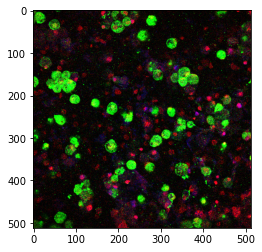

In [6]:
plt.imshow(cell_im)

Note: The cell image being read in is from the OGD Severity study by Rick Liao, Andrea Joseph, Mengying Zhang, Mike McKenna, Jeremy Filteau, and Hawley Helmbrecht within the Nance lab. It is an image taken from the thalamus with a costain DAPI/PI/Iba

In [5]:
red_cell_im = cell_im[:,:, 0]
green_cell_im = cell_im[:,:,1]
blue_cell_im = cell_im[:,:,2]

In [6]:
thresh_otsu = skimage.filters.threshold_otsu(green_cell_im)

In [7]:
thresh_otsu

191

In [8]:
binary_otsu = green_cell_im > thresh_otsu  # boolean

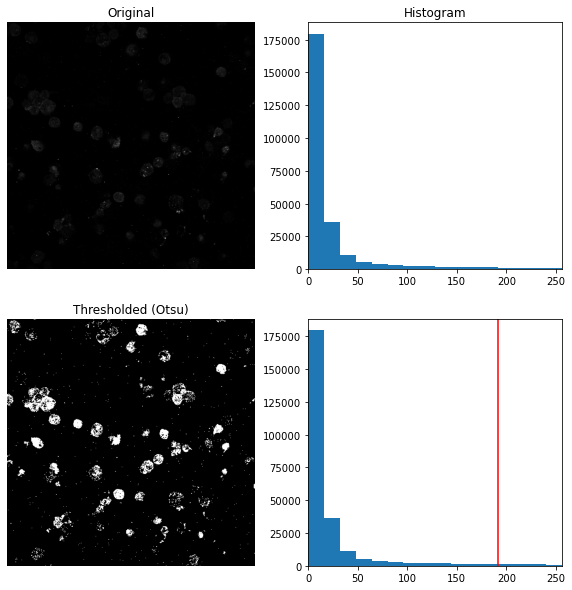

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(green_cell_im, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(green_cell_im.ravel(), bins=256)
ax[0, 1].set_title('Histogram')
ax[0, 1].set_xlim((0, 256)) 

ax[1, 0].imshow(binary_otsu, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(green_cell_im.ravel(), bins=256)
ax[1, 1].axvline(thresh_otsu, color='r')
ax[1, 1].set_xlim((0, 256)) 

for a in ax[:, 0]:
    a.axis('off')
plt.show()

*removing small objects from the threshold image*

In [14]:
new_binary_otsu = morphology.remove_small_objects(binary_otsu, min_size=64)

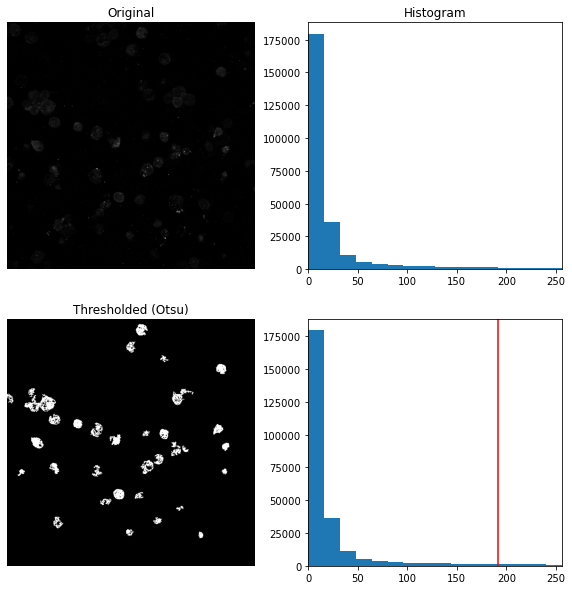

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(green_cell_im, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(green_cell_im.ravel(), bins=256)
ax[0, 1].set_title('Histogram')
ax[0, 1].set_xlim((0, 256)) 

ax[1, 0].imshow(new_binary_otsu, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(green_cell_im.ravel(), bins=256)
ax[1, 1].axvline(thresh_otsu, color='r')
ax[1, 1].set_xlim((0, 256)) 

for a in ax[:, 0]:
    a.axis('off')
plt.show()

*labeling the image*

In [16]:
label_image = label(new_binary_otsu)
image_label_overlay = label2rgb(label_image, image=new_binary_otsu, bg_label=0)

*viewing the labeled image with area boxes*

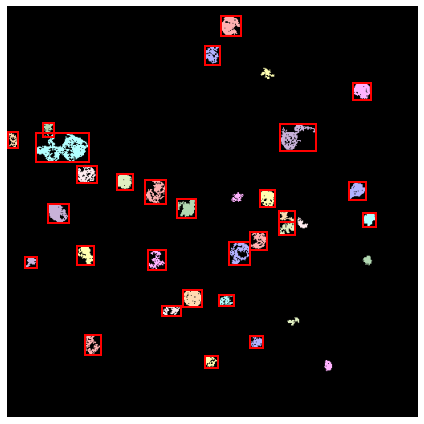

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

*Filling in shape holes to see if it improves our labeling*

In [19]:
new_binary_otsu = ndimage.binary_fill_holes(new_binary_otsu)

In [21]:
label_image = label(new_binary_otsu)
image_label_overlay = label2rgb(label_image, image=new_binary_otsu, bg_label=0)

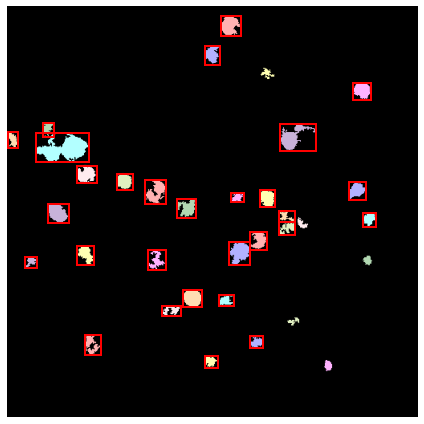

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

*Get a .csv file of multiple regionprops/shape features*

In [25]:
props = measure.regionprops_table(label_image, properties=('perimeter', 'area', 'major_axis_length', 'minor_axis_length'))

In [26]:
green_shape_features = pd.DataFrame(props)

In [31]:
green_shape_features.head()

,perimeter,area,major_axis_length,minor_axis_length,circularity
0,92.325902,398,24.750160,21.789002,0.586740
1,88.497475,273,22.775196,17.030246,0.438037
2,62.455844,96,15.844868,11.405677,0.309268
3,73.597980,326,21.986401,19.258513,0.756303
4,66.319805,141,18.364886,11.386040,0.402849


*calculating the circularity*

In [28]:
green_shape_features['circularity'] = 4*np.pi*green_shape_features.area/green_shape_features.perimeter**2

In [30]:
green_shape_features.head()

,perimeter,area,major_axis_length,minor_axis_length,circularity
0,92.325902,398,24.750160,21.789002,0.586740
1,88.497475,273,22.775196,17.030246,0.438037
2,62.455844,96,15.844868,11.405677,0.309268
3,73.597980,326,21.986401,19.258513,0.756303
4,66.319805,141,18.364886,11.386040,0.402849


*calculating the aspect ratio: computer find the center point and major axis is the longest line going through the center point and the minor axis is the shortest line that goes through the center point and is perpendicualr to the major axis*

In [32]:
green_shape_features['aspect_ratio'] = green_shape_features.major_axis_length/green_shape_features.minor_axis_length

In [33]:
green_shape_features.head()

,perimeter,area,major_axis_length,minor_axis_length,circularity,aspect_ratio
0,92.325902,398,24.750160,21.789002,0.586740,1.135901
1,88.497475,273,22.775196,17.030246,0.438037,1.337338
2,62.455844,96,15.844868,11.405677,0.309268,1.389209
3,73.597980,326,21.986401,19.258513,0.756303,1.141646
4,66.319805,141,18.364886,11.386040,0.402849,1.612930


*Plotting some values*

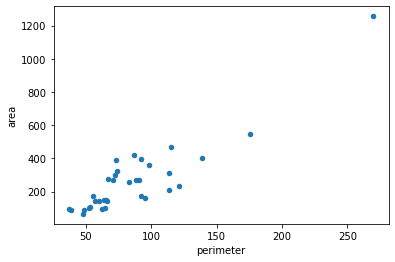

In [34]:
green_shape_features['stain'] = 'iba1'
green_shape_features.plot(x ='perimeter', y='area', kind = 'scatter')

*saving as a CSV file*

In [35]:
green_shape_features.to_csv('green_shape_features.csv')